In [1]:
import numpy as np
import pandas as pd
import yaml

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error, roc_curve, roc_auc_score, auc, precision_recall_curve

import matplotlib.pyplot as plt
import seaborn as sns

# Load the configuration file

In [2]:
with open("workspace/config.yml", "r") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

lame = config['lame']
path = f"{config['path_to_data']}/{lame}"

# Load the data

In [3]:
# Load the selected peaks in the region with the given frequency
peaks = pd.read_csv(f"{path}/results/mse_spectra_region.csv")

# Load the selected region pixels features
pixels = pd.read_csv(f"{path}/results/mse_pixels_region.csv")

# Plot the pixels densities extracted from the IHC images

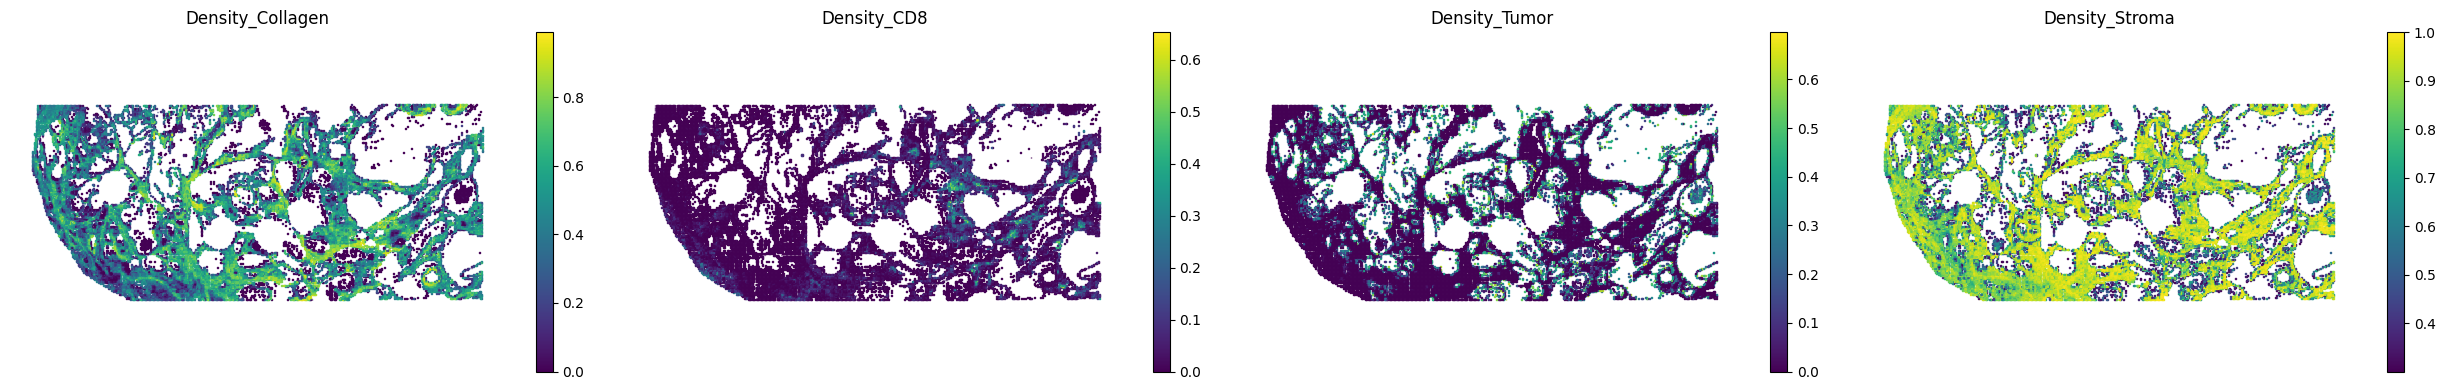

In [4]:
# Determine the densities of the selected pixels
densities = [col for col in pixels.columns if 'Density' in col][2:]

fig, axs = plt.subplots(1, 4, figsize=(25, 4), tight_layout=True)
for ax in axs.flatten():
    ax.axis('off')

for ax, density in zip(axs.flatten(), densities):
    ax.scatter(x=pixels['x_warped'], y=pixels['y_warped'], c=pixels[density], cmap='viridis', s=0.5, marker='s')
    ax.set_title(density)
    ax.invert_yaxis()
    ax.axis('equal')
    fig.colorbar(ax.collections[0], ax=ax)

plt.show()

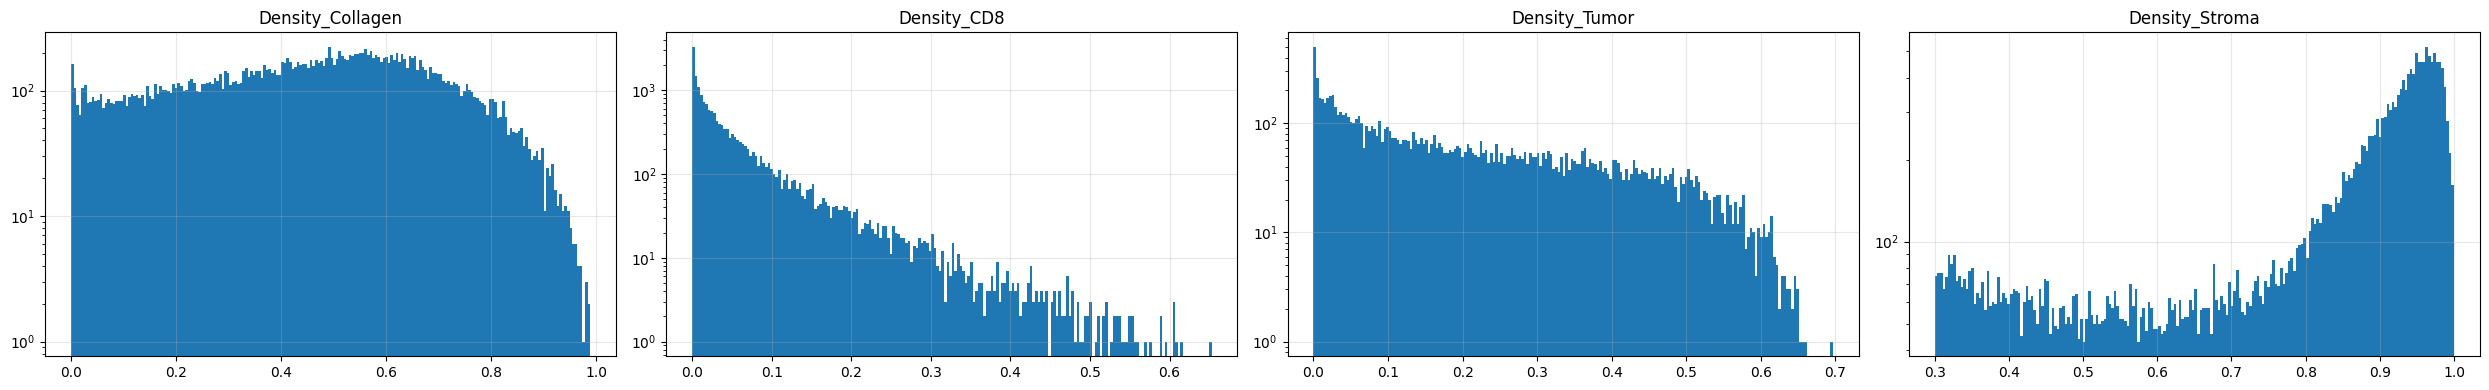

In [5]:
# Make a histogram of the pixel densities data
fig, axs = plt.subplots(1, 4, figsize=(25, 4), tight_layout=True)

for ax, density in zip(axs.flatten(), densities):
    ax.hist(pixels[density][pixels[density] != 0], bins=200)
    ax.set_title(density)
    ax.set_yscale('log')
    ax.grid(alpha=0.3)

plt.show()

# Define a threshold for the pixel densities, then plot the density thresholded masks

In [6]:
threshold = {
    'Density_CD8': 0.03,
    'Density_Tumor': 0.1,
    'Density_Stroma': 0.8,
    'Density_Collagen': 0.5
    }

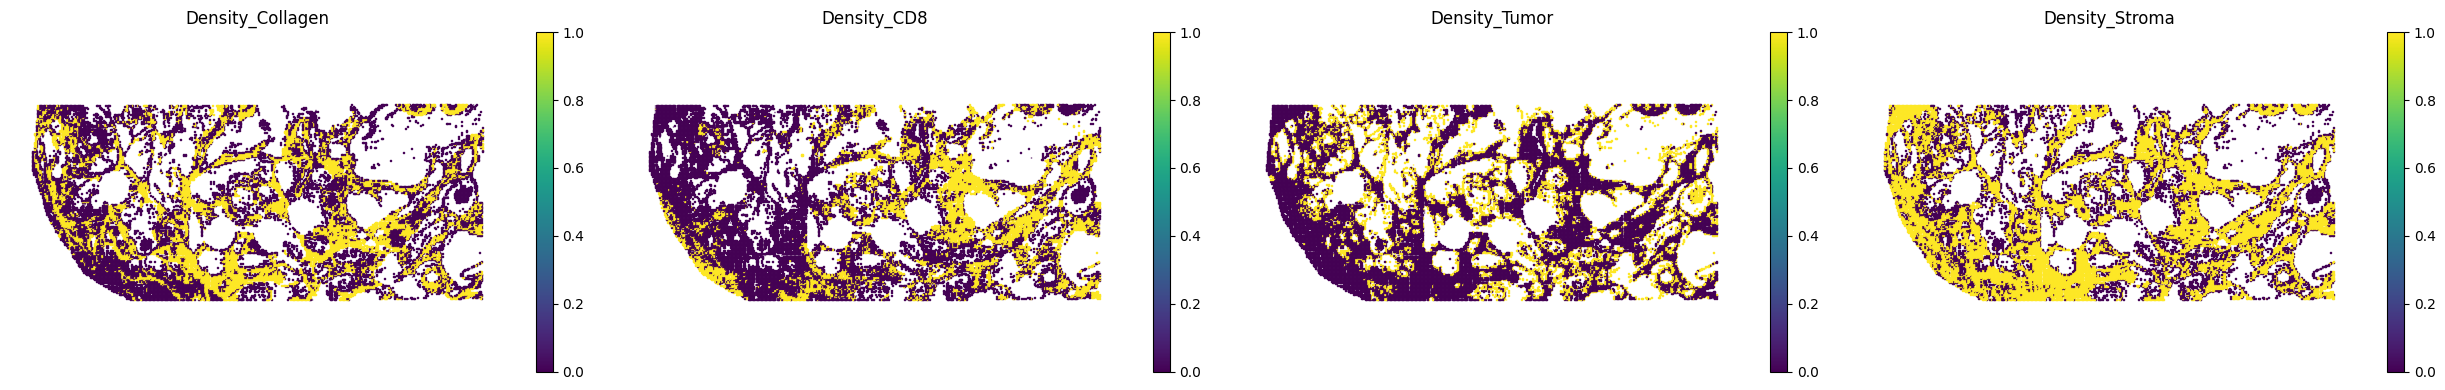

In [7]:
# plot the pixels densities with threshold
fig, axs = plt.subplots(1, 4, figsize=(25, 4), tight_layout=True)
for ax in axs.flatten():
    ax.axis('off')

for ax, density in zip(axs.flatten(), densities):
    ax.scatter(x=pixels['x_warped'], y=pixels['y_warped'], c=pixels[density] > threshold[density], cmap='viridis', s=0.5, marker='s')
    ax.set_title(density)
    ax.invert_yaxis()
    ax.axis('equal')
    fig.colorbar(ax.collections[0], ax=ax)

plt.show()

# Split the data into training and testing sets

In [8]:
# Sample data
X = peaks.values
y = pixels['Density_CD8'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Perform a linear regression

In [9]:
# Create a linear regression model
model_reg = LinearRegression()

# Train the model
model_reg.fit(X_train, y_train)

# Make predictions
y_pred = model_reg.predict(X_test)

# Compute R-squared
r2_train = model_reg.score(X_train, y_train)
r2_test = r2_score(y_test, y_pred)

# Compute the mean squared error
mse_train = mean_squared_error(y_train, model_reg.predict(X_train))
mse_test = mean_squared_error(y_test, y_pred)

print(f"Mean Squared Error (train): {mse_train:.5f}")
print(f"Mean Squared Error (test): {mse_test:.5f}")
print(f"R-squared (train): {r2_train:.2f}")
print(f"R-squared (test): {r2_test:.2f}")

Mean Squared Error (train): 0.00335
Mean Squared Error (test): 0.00336
R-squared (train): 0.30
R-squared (test): 0.22


In [10]:
np.sqrt(r2_train)

np.float64(0.5431504824537415)

In [11]:
# Create a linear regression model
model_reg = LinearRegression()

# Train the model
model_reg.fit(X, y)

print(f"Pearson correlation: {np.corrcoef(y, model_reg.predict(X))[0, 1]:.2f}")
print(f"Spearman correlation: {np.corrcoef(y, model_reg.predict(X))[0, 1]:.2f}")

Pearson correlation: 0.54
Spearman correlation: 0.54


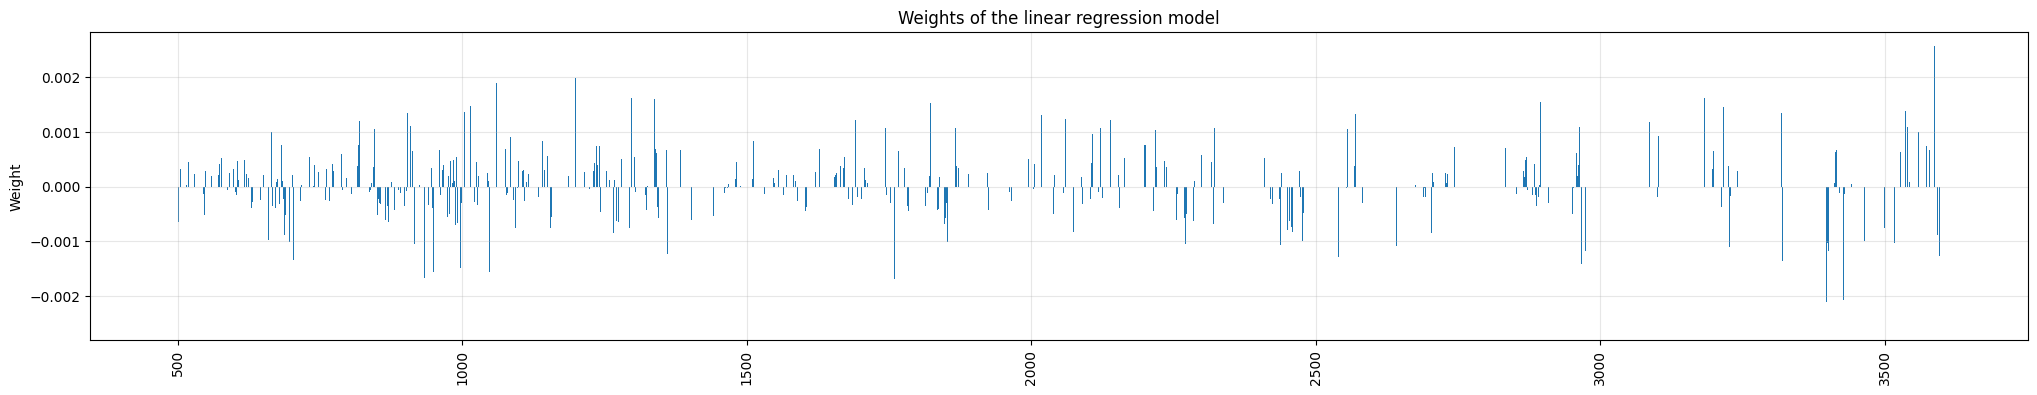

In [12]:
# Compute the weights of the model
weights = model_reg.coef_

# Plot the weights
plt.figure(figsize=(25, 4))
plt.bar(peaks.columns.astype(float), weights)
plt.xticks(rotation=90)
plt.ylabel('Weight')
plt.title('Weights of the linear regression model')
plt.grid(alpha=0.3)
plt.show()

In [13]:
# Compute the Pearson correlation between each mass in the peaks and the CD8 density
corr_pearson = []
for mass in peaks.columns:
    corr = np.corrcoef(peaks[mass], pixels["Density_CD8"])[0, 1]
    corr_pearson.append(corr)

# Compute the Spearman correlation between each mass in the peaks and the CD8 density
corr_spearman = []
for mass in peaks.columns:
    corr = peaks[mass].corr(pixels["Density_CD8"], method='spearman')
    corr_spearman.append(corr)

# Compute the log2 fold change between the CD8 high and low groups
fold_change = []
for mass in peaks.columns:
    high = peaks[mass][pixels["Density_CD8"] > threshold["Density_CD8"]]
    low = peaks[mass][pixels["Density_CD8"] <= threshold["Density_CD8"]]
    fc = np.log2(high.mean() / low.mean())
    fold_change.append(fc)

# Create a dataframe with the peaks and their weights
cd8_peaks = pd.DataFrame(data={'mz': peaks.columns,
                               'weight': weights,
                               'corr_pearson': corr_pearson,
                               'corr_spearman': corr_spearman,
                               'fold_change': fold_change})

# Transform the cd8_peaks datatypes
cd8_peaks['mz'] = cd8_peaks['mz'].astype(float)

cd8_peaks.head()

,mz,weight,corr_pearson,corr_spearman,fold_change
0,501.295933,-0.000640,-0.055793,-0.092335,-1.785271
1,502.240833,0.000383,-0.055570,-0.097988,-2.106131
2,503.267481,-0.000110,-0.095287,-0.129366,-1.099483
3,504.253660,0.000330,-0.063930,-0.080557,-0.941757
4,515.322157,0.000022,-0.059412,0.045060,-0.385375


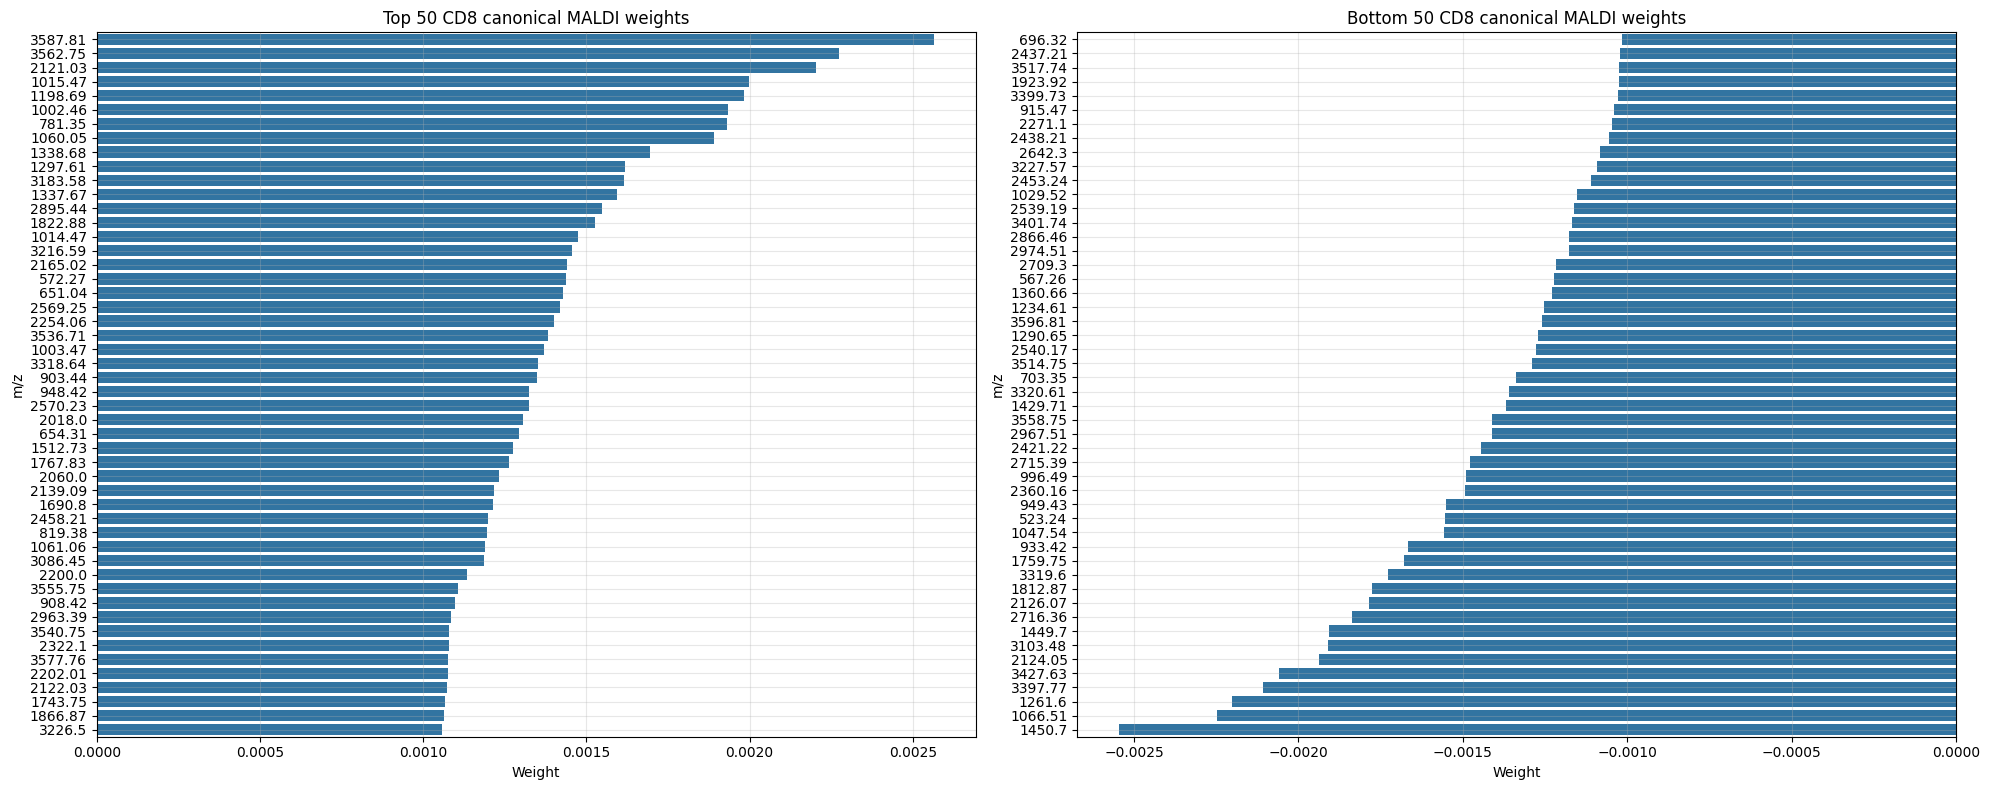

In [14]:
# Order the peaks by their weights
cd8_peaks_ordered = cd8_peaks.sort_values(by='weight', ascending=False)

# Transform the cd8_peaks datatypes
cd8_peaks_ordered['mz'] = cd8_peaks_ordered['mz'].round(2).astype(str)

# Plot the top 50 peaks
fig, ax = plt.subplots(1, 2, figsize=(20, 8), tight_layout=True)
sns.barplot(data=cd8_peaks_ordered.head(50), x='weight', y='mz', orient="h", ax=ax[0])
ax[0].set_title("Top 50 CD8 canonical MALDI weights")
ax[0].set_xlabel("Weight")
ax[0].set_ylabel("m/z")
ax[0].grid(alpha=0.3)

sns.barplot(data=cd8_peaks_ordered.tail(50), x='weight', y='mz', orient="h", ax=ax[1])
ax[1].set_title("Bottom 50 CD8 canonical MALDI weights")
ax[1].set_xlabel("Weight")
ax[1].set_ylabel("m/z")
ax[1].grid(alpha=0.3)

plt.show()

In [15]:
# Extract the peaks with a low correlations and high weights
non_cd8_signal = np.array([(np.abs(cd8_peaks['corr_pearson']) < 0.04) & (np.abs(cd8_peaks['weight']) > 0.001)])[0]

# Compute how many peaks are in the non_cd8_signal
print(f"Number of peaks with low correlations and high weights: {np.sum(non_cd8_signal)}")

cd8_peaks.loc[non_cd8_signal]

Number of peaks with low correlations and high weights: 67


,mz,weight,corr_pearson,corr_spearman,fold_change
67,651.043633,0.001428,-0.027955,-0.064814,-2.177563
69,654.307183,0.001292,-0.019335,-0.025500,-0.961704
94,696.317411,-0.001016,-0.023019,-0.023246,-0.578266
128,781.352813,0.001931,-0.031359,-0.067347,-1.080298
153,845.416184,0.001050,0.023165,-0.002429,0.194122
...,...,...,...,...,...
806,3558.752769,-0.001411,-0.012988,0.007265,-0.231621
808,3562.746725,0.002273,-0.002277,0.012125,0.042546
811,3577.756280,0.001076,0.000281,0.016407,0.003318
813,3587.811634,0.002564,0.003433,0.019397,0.084227


In [16]:
for mass in cd8_peaks.loc[non_cd8_signal, 'mz']:
    print(mass)

651.04363287131
654.307183210627
696.317410850756
781.352813293924
845.416183963798
903.435335908078
908.418414654577
933.423136486573
949.431815371767
1002.4560430561
1003.47294827209
1014.47207244831
1015.47257393077
1060.05380718957
1061.06124594889
1066.50518768685
1198.68562681108
1261.60340854763
1290.64871619558
1360.66146552022
1429.71133910111
1449.69514869076
1450.69975396242
1759.75213758913
1812.87386228578
2124.053133081
2126.06981818664
2233.07620981364
2360.16037536405
2421.21575299388
2453.23519608184
2458.21197898194
2539.19046368552
2570.2269238009
2642.30255468568
2709.30272261852
2715.38785388909
2716.36041035303
2866.45981519667
2895.4387608474
2963.3851516039
2967.51279378939
2974.51081949527
3086.45054231209
3103.47994978345
3183.58036149938
3216.5942375128
3226.49513007788
3227.57430032204
3318.64489203202
3319.59524083477
3320.60699148935
3397.76619087372
3399.72517396806
3401.73936085588
3427.62675050142
3432.73301532191
3514.75031279478
3517.74368360178
3536.

In [17]:
for mass in cd8_peaks_ordered['mz'][:10]:
    print(mass)

3587.81
3562.75
2121.03
1015.47
1198.69
1002.46
781.35
1060.05
1338.68
1297.61


In [18]:
# Wright the mz of the peaks with low correlations and high weights in a file for mascot search
cd8_peaks.loc[non_cd8_signal, 'mz'].to_csv(f"{path}/results/non_cd8_signal.csv", index=False)

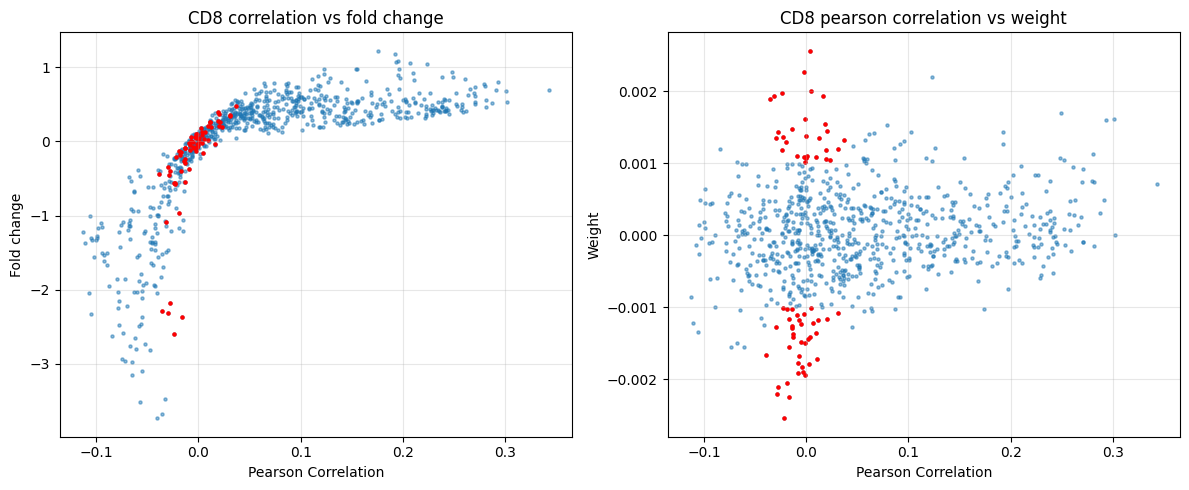

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5), tight_layout=True)
ax = ax.flatten()

ax[0].scatter(cd8_peaks['corr_pearson'], cd8_peaks['fold_change'], alpha=0.5, s=5)
ax[0].scatter(cd8_peaks['corr_pearson'][non_cd8_signal], cd8_peaks['fold_change'][non_cd8_signal], s=5, color='red')

ax[0].set_title("CD8 correlation vs fold change")
ax[0].set_xlabel("Pearson Correlation")
ax[0].set_ylabel("Fold change")
ax[0].grid(alpha=0.3)

ax[1].scatter(cd8_peaks['corr_pearson'], cd8_peaks['weight'], alpha=0.5, s=5)
ax[1].scatter(cd8_peaks['corr_pearson'][non_cd8_signal], cd8_peaks['weight'][non_cd8_signal], s=5, color='red')
ax[1].set_title("CD8 pearson correlation vs weight")
ax[1].set_xlabel("Pearson Correlation")
ax[1].set_ylabel("Weight")
ax[1].grid(alpha=0.3)

plt.show()

In [20]:
# Adjust the y values to be binary
y_train = y_train > threshold['Density_CD8']
y_test = y_test > threshold['Density_CD8']

# Create a logistic regression model
model_log = LogisticRegression(max_iter=10**6)

# Train the model
model_log.fit(X_train, y_train)

LogisticRegression(max_iter=1000000)

In [21]:
# Make predictions
y_pred = model_log.predict(X_test)

# Compute the accuracy using accuracy_score
accuracy_train = model_log.score(X_train, y_train)
accuracy_test = accuracy_score(y_test, y_pred)

print(f"Accuracy (train): {accuracy_train:.2f}")
print(f"Accuracy (test): {accuracy_test:.2f}")

Accuracy (train): 0.78
Accuracy (test): 0.75


# Sensitivity, specificity and ROC curve

ROC AUC: 0.78
Sensitivity: 0.50
Specificity: 0.86


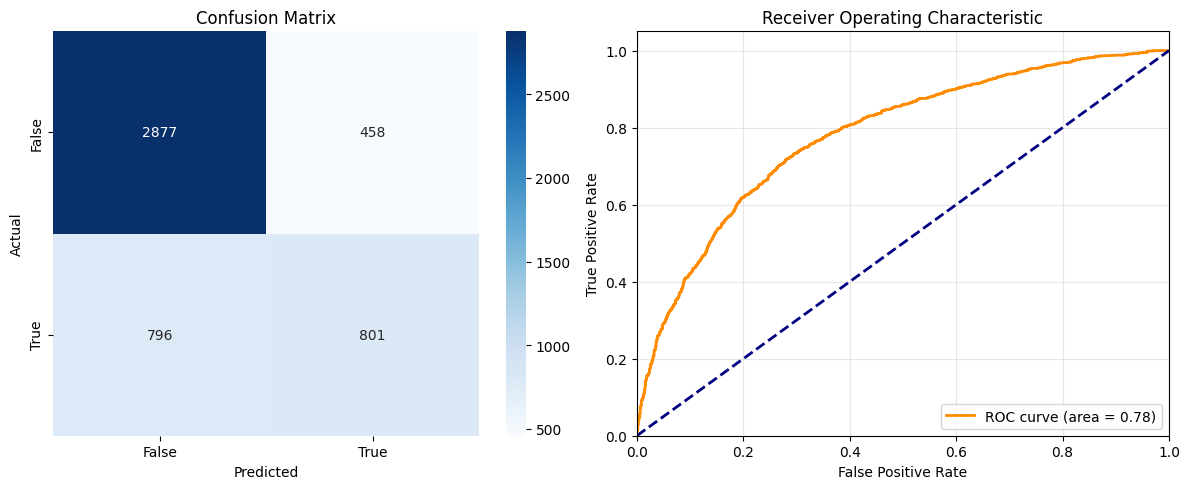

In [22]:
# Compute the True Positives, True Negatives, False Positives and False Negatives
true_positives = np.sum((y_test == 1) & (y_pred == 1))
true_negatives = np.sum((y_test == 0) & (y_pred == 0))
false_positives = np.sum((y_test == 0) & (y_pred == 1))
false_negatives = np.sum((y_test == 1) & (y_pred == 0))

# Compute the Sensitivity and Specificity
sensitivity = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)

# Compute the confusion matrix
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])

# Compute the ROC curve
fpr, tpr, _ = roc_curve(y_test, model_log.predict_proba(X_test)[:, 1])

# Compute the ROC AUC
roc_auc = roc_auc_score(y_test, model_log.predict_proba(X_test)[:, 1])

print(f"ROC AUC: {roc_auc:.2f}")
print(f"Sensitivity: {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")

# Plot the confusion matrix and the ROC curve
fig, ax = plt.subplots(1, 2, figsize=(12, 5), tight_layout=True)

sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title("Confusion Matrix")
ax[0].set_xlabel("Predicted")
ax[0].set_ylabel("Actual")

ax[1].plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
ax[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax[1].set_xlim([0.0, 1.0])
ax[1].set_ylim([0.0, 1.05])
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('Receiver Operating Characteristic')
ax[1].legend(loc="lower right")
ax[1].grid(alpha=0.3)

plt.show()

# Precision and Recall curve

AUC: 0.63
Intersection threshold: 0.42


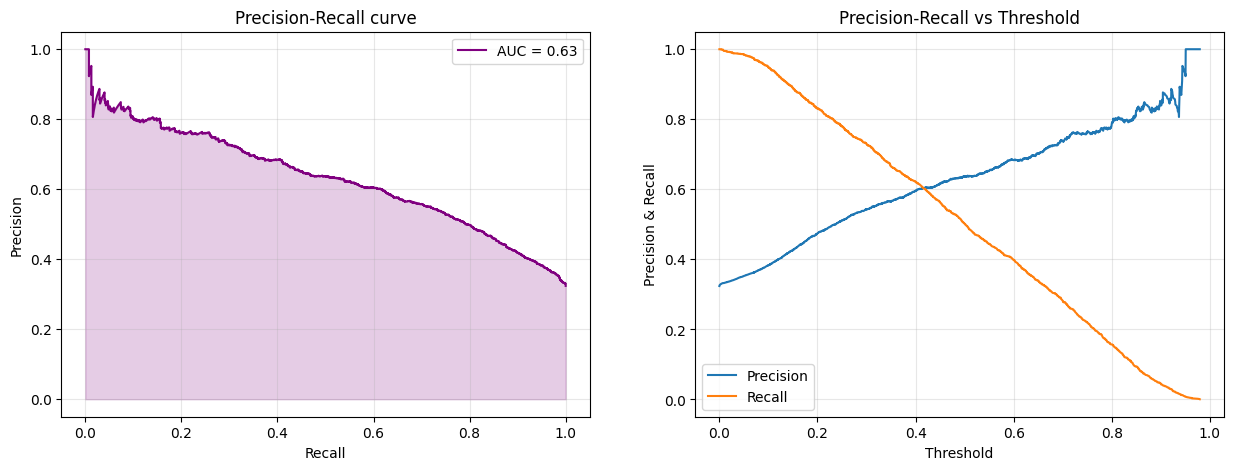

In [23]:
# Calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, model_log.predict_proba(X_test)[:, 1])

# Compute the AUC
auc_score = auc(recall, precision)

# Calculate the intersection threshold
intersection_threshold = thresholds[np.argmin(np.abs(recall - precision))]

print(f"AUC: {auc_score:.2f}")
print(f"Intersection threshold: {intersection_threshold:.2f}")

# Plot the precision-recall curve
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(recall, precision, color="purple", label=f"AUC = {auc_score:.2f}")
ax[0].fill_between(recall, precision, alpha=0.2, color="purple")
ax[0].set_xlabel("Recall")
ax[0].set_ylabel("Precision")
ax[0].set_title(f"Precision-Recall curve")
ax[0].grid(alpha=0.3)
ax[0].legend()

ax[1].plot(thresholds, precision[:-1], label="Precision")
ax[1].plot(thresholds, recall[:-1], label="Recall")
ax[1].set_xlabel("Threshold")
ax[1].set_ylabel("Precision & Recall")
ax[1].set_title(f"Precision-Recall vs Threshold")
ax[1].grid(alpha=0.3)
ax[1].legend()

plt.show()

Accuracy: 0.74
True Positives: 964
True Negatives: 2703
False Positives: 632
False Negatives: 633
Sensitivity: 0.60
Specificity: 0.81


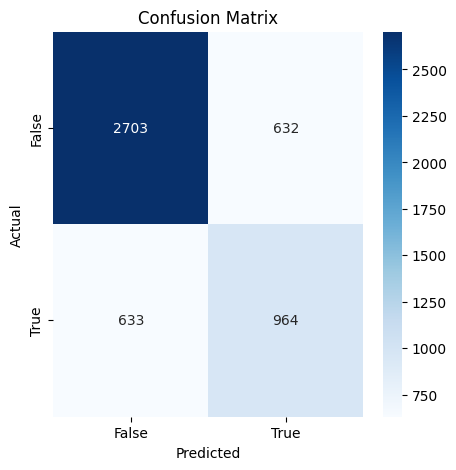

In [24]:
# Predict the CD8 density using the logistic regression model with the intersection threshold
y_pred = model_log.predict_proba(X_test)[:, 1] > intersection_threshold

# Compute the accuracy using accuracy_score
accuracy = accuracy_score(y_test, y_pred)

# Compute the True Positives, True Negatives, False Positives and False Negatives
true_positives = np.sum((y_test == 1) & y_pred)
true_negatives = np.sum((y_test == 0) & ~y_pred)
false_positives = np.sum((y_test == 0) & y_pred)
false_negatives = np.sum((y_test == 1) & ~y_pred)

# Compute the Sensitivity and Specificity
sensitivity = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)

# Compute the confusion matrix
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])

print(f"Accuracy: {accuracy:.2f}")
print(f"True Positives: {true_positives}")
print(f"True Negatives: {true_negatives}")
print(f"False Positives: {false_positives}")
print(f"False Negatives: {false_negatives}")
print(f"Sensitivity: {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")

# Plot the confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Lasso regularization (L1)

In [25]:
# Create a logistic regression model with Lasso regularization (L1)
model_log_l1 = LogisticRegression(max_iter=10**6, penalty='l1', solver='liblinear')

# Train the model
model_log_l1.fit(X_train, y_train)

LogisticRegression(max_iter=1000000, penalty='l1', solver='liblinear')

In [26]:
# Make predictions
y_pred = model_log_l1.predict(X_test)

# Compute the accuracy using accuracy_score
accuracy_train = model_log_l1.score(X_train, y_train)
accuracy_test = accuracy_score(y_test, y_pred)

print(f"Accuracy (train): {accuracy_train:.2f}")
print(f"Accuracy (test): {accuracy_test:.2f}")

Accuracy (train): 0.78
Accuracy (test): 0.74


True Positives: 797
True Negatives: 2876
False Positives: 459
False Negatives: 800
Sensitivity: 0.50
Specificity: 0.86
ROC AUC: 0.78


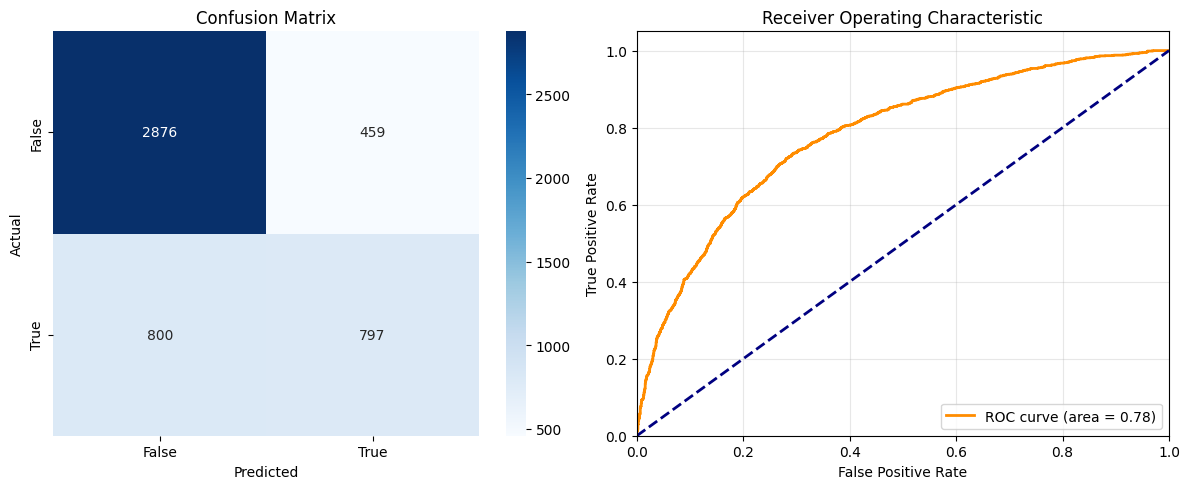

In [29]:
# Compute the True Positives, True Negatives, False Positives and False Negatives
true_positives = np.sum((y_test == 1) & y_pred)
true_negatives = np.sum((y_test == 0) & ~y_pred)
false_positives = np.sum((y_test == 0) & y_pred)
false_negatives = np.sum((y_test == 1) & ~y_pred)

# Compute the Sensitivity and Specificity
sensitivity = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)

# Compute the confusion matrix
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])

print(f"True Positives: {true_positives}")
print(f"True Negatives: {true_negatives}")
print(f"False Positives: {false_positives}")
print(f"False Negatives: {false_negatives}")
print(f"Sensitivity: {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")

# Compute the ROC curve
fpr, tpr, _ = roc_curve(y_test, model_log_l1.predict_proba(X_test)[:, 1])

# Compute the ROC AUC
roc_auc = roc_auc_score(y_test, model_log_l1.predict_proba(X_test)[:, 1])

print(f"ROC AUC: {roc_auc:.2f}")

# Plot the confusion matrix and the ROC curve
fig, ax = plt.subplots(1, 2, figsize=(12, 5), tight_layout=True)

sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title("Confusion Matrix")
ax[0].set_xlabel("Predicted")
ax[0].set_ylabel("Actual")

ax[1].plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
ax[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax[1].set_xlim([0.0, 1.0])
ax[1].set_ylim([0.0, 1.05])
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('Receiver Operating Characteristic')
ax[1].legend(loc="lower right")
ax[1].grid(alpha=0.3)

plt.show()

AUC: 0.63
Intersection threshold: 0.42


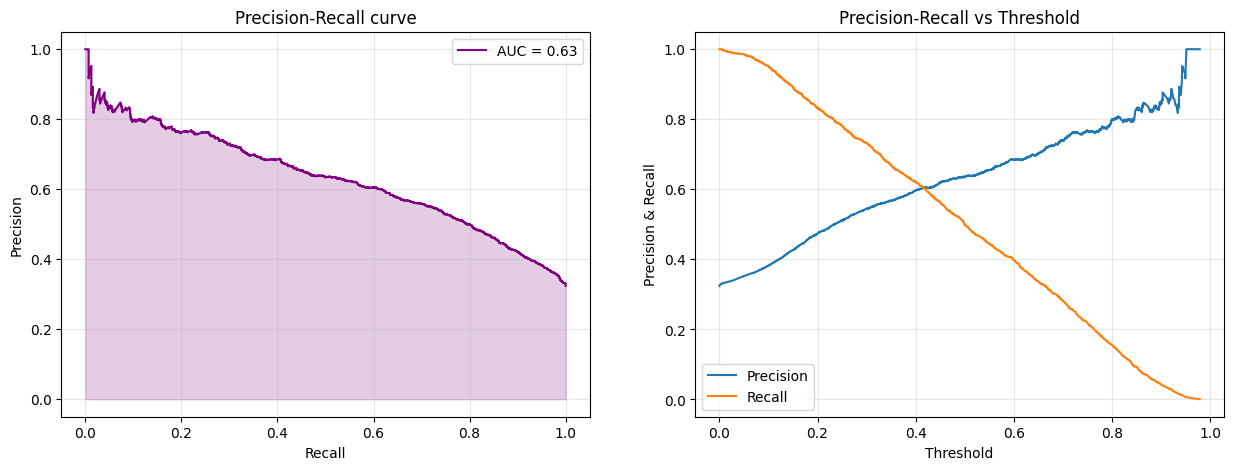

In [30]:
# Calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, model_log_l1.predict_proba(X_test)[:, 1])

# Compute the AUC
auc_score = auc(recall, precision)

# Calculate the intersection threshold
intersection_threshold = thresholds[np.argmin(np.abs(recall - precision))]

print(f"AUC: {auc_score:.2f}")
print(f"Intersection threshold: {intersection_threshold:.2f}")

# Plot the precision-recall curve
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(recall, precision, color="purple", label=f"AUC = {auc_score:.2f}")
ax[0].fill_between(recall, precision, alpha=0.2, color="purple")
ax[0].set_xlabel("Recall")
ax[0].set_ylabel("Precision")
ax[0].set_title(f"Precision-Recall curve")
ax[0].grid(alpha=0.3)
ax[0].legend()

ax[1].plot(thresholds, precision[:-1], label="Precision")
ax[1].plot(thresholds, recall[:-1], label="Recall")
ax[1].set_xlabel("Threshold")
ax[1].set_ylabel("Precision & Recall")
ax[1].set_title(f"Precision-Recall vs Threshold")
ax[1].grid(alpha=0.3)
ax[1].legend()

plt.show()